# Prédiction du niveau calorique des recettes avec Random Forest

Ce notebook utilise un classifieur Random Forest pour prédire le niveau calorique des recettes (BAS/MOYEN/HAUT) basé sur les ingrédients et instructions, avec préprocessing NLP et interprétation SHAP.

## Objectifs:
- Classifier les recettes en 3 niveaux caloriques (bas < 250, moyen 250-500, haut > 500)
- Utiliser Random Forest avec bonnes pratiques
- Préprocessing NLP des ingrédients et instructions
- Interprétation avec SHAP (explicabilité très importante dans la nutrition)

## TODO:
# - Lemmatisation + ordre des ingrédients avant vectorisation ?
# - Equilibrage des classes
# - LabelEncoder pour les classes

## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import shap
import re
import ast
import warnings
warnings.filterwarnings('ignore')

# Configuration pour l'affichage
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries importées avec succès!")


Libraries importées avec succès!


## 2. Chargement et exploration des données

In [3]:
# Chargement des données
df = pd.read_csv('data/RAW_recipes.csv')
print(f"Forme du dataset: {df.shape}")
print(f"\nColonnes: {df.columns.tolist()}")
print(f"\nPremières lignes:")
df.head()


Forme du dataset: (231637, 12)

Colonnes: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']

Premières lignes:


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
# Informations sur le dataset
df.info()
print("\nValeurs manquantes:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB

Valeurs manquantes:
name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
ste

## 3. Préprocessing des données nutritionnelles

In [ ]:
def parse_nutrition(nutrition_str):
    """Parse la colonne nutrition pour extraire les valeurs nutritionnelles"""
    try:
        # Convertir la chaîne en liste
        nutrition_list = ast.literal_eval(nutrition_str)
        return nutrition_list
    except:
        return [0, 0, 0, 0, 0, 0, 0]

# Appliquer le parsing
df['nutrition_parsed'] = df['nutrition'].apply(parse_nutrition)

# Extraire les valeurs nutritionnelles (l'ordre est: calories, total_fat, sugar, sodium, protein, saturated_fat, carbohydrates)
nutrition_columns = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
for i, col in enumerate(nutrition_columns):
    df[col] = df['nutrition_parsed'].apply(lambda x: x[i] if len(x) > i else 0)

# Supprimer les valeurs aberrantes de calories (> 3000 ou < 0)
df = df[(df['calories'] >= 0) & (df['calories'] <= 3000)]

print(f"Statistiques des calories après nettoyage:")
print(df['calories'].describe())


Statistiques des calories après nettoyage:
count    228486.000000
mean        408.524812
std         384.645804
min           0.000000
25%         172.600000
50%         309.100000
75%         507.900000
max        2999.800000
Name: calories, dtype: float64


## 4. Création de la variable cible


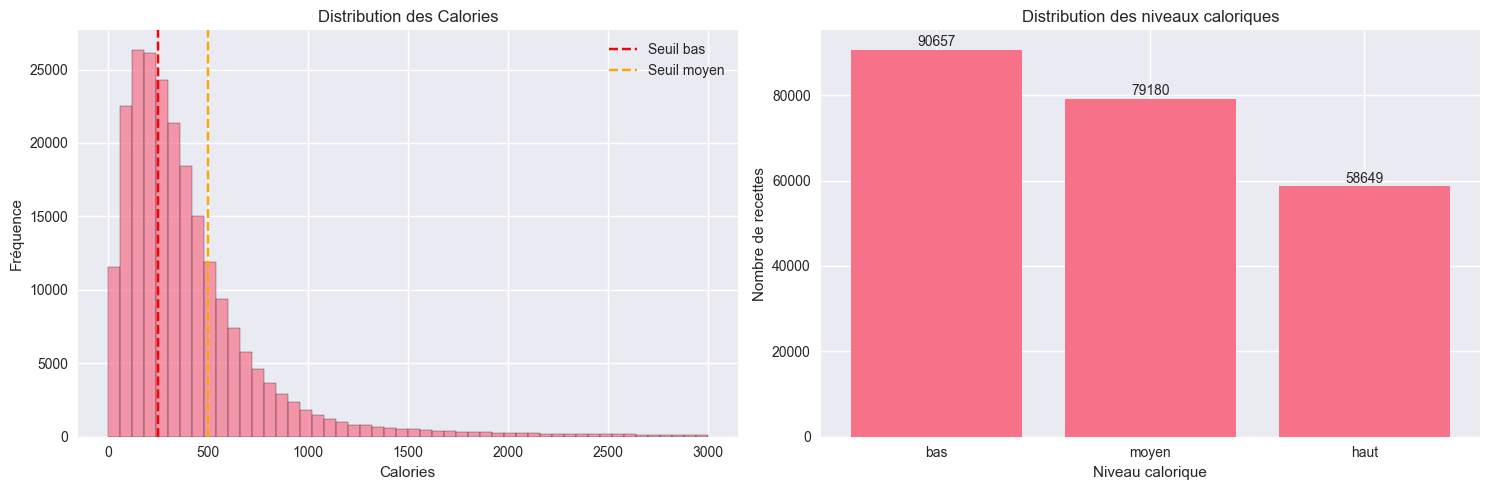

Distribution des niveaux caloriques:
calorie_level
bas      90657
moyen    79180
haut     58649
Name: count, dtype: int64

Pourcentages:
calorie_level
bas      39.677267
moyen    34.654202
haut     25.668531
Name: proportion, dtype: float64


In [ ]:
def classify_calories(cal):
    """Classifie les calories en trois catégories"""
    if cal < 250:
        return 'bas'
    elif cal <= 500:
        return 'moyen'
    else:
        return 'haut'

# Créer la variable cible
df['calorie_level'] = df['calories'].apply(classify_calories)

# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des calories
axes[0].hist(df['calories'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des calories')
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(x=250, color='red', linestyle='--', label='Seuil bas')
axes[0].axvline(x=500, color='orange', linestyle='--', label='Seuil moyen')
axes[0].legend()

# Distribution des niveaux caloriques
calorie_counts = df['calorie_level'].value_counts()
axes[1].bar(calorie_counts.index, calorie_counts.values)
axes[1].set_title('Distribution des niveaux caloriques')
axes[1].set_xlabel('Niveau calorique')
axes[1].set_ylabel('Nombre de recettes')

# Ajouter les valeurs sur les barres
for i, v in enumerate(calorie_counts.values):
    axes[1].text(i, v + 100, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Distribution des niveaux caloriques:")
print(df['calorie_level'].value_counts())
print("\nPourcentages:")
print(df['calorie_level'].value_counts(normalize=True) * 100)


## 5. Préprocessing NLP des ingrédients et instructions

In [ ]:
def clean_text(text):
    """Nettoie le texte pour l'analyse NLP"""
    if pd.isna(text):
        return ""
    
    # Convertir en string si ce n'est pas déjà fait
    text = str(text)
    
    # Supprimer les crochets et guillemets
    text = re.sub(r"[\[\]'\"]", "", text)
    
    # Remplacer les virgules par des espaces
    text = re.sub(r",", " ", text)
    
    # Supprimer les caractères spéciaux sauf les espaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer les espaces multiples
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()

# Nettoyer les ingrédients et instructions
df['ingredients_cleaned'] = df['ingredients'].apply(clean_text)

# Supprimer les recettes avec du texte vide
df = df[df['ingredients_cleaned'].str.len() > 10]

print(f"Nombre de recettes après nettoyage: {len(df)}")
print("\nExemple de texte nettoyé:")
# print(df['combined_text'].iloc[0][:200] + "...")
print(df['ingredients_cleaned'].iloc[0][:200] + "...")



Nombre de recettes après nettoyage: 230588

Exemple de texte nettoyé:
winter squash mexican seasoning mixed spice honey butter olive oil salt make a choice and proceed with recipe depending on size of squash cut into half or fourths remove seeds for spicy squash drizzle...


## 6. Vectorisation TF-IDF et préparation des données

In [ ]:
# Paramètres TF-IDF optimisés
tfidf = TfidfVectorizer(
    max_features=5000,  # Limiter le nombre de features
    min_df=5,          # Ignorer les termes qui apparaissent dans moins de 5 documents
    max_df=0.8,        # Ignorer les termes qui apparaissent dans plus de 80% des documents
    stop_words='english',
    ngram_range=(1, 2)  # Utiliser des unigrammes et bigrammes
)

# Vectoriser le texte

# X_tfidf = tfidf.fit_transform(df['combined_text'])
X_tfidf = tfidf.fit_transform(df['ingredients_cleaned'])
print(f"Forme de la matrice TF-IDF: {X_tfidf.shape}")

# Préparer les variables
X = X_tfidf
y = df['calorie_level']

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille du jeu d'entraînement: {X_train.shape[0]}")
print(f"Taille du jeu de test: {X_test.shape[0]}")
print(f"\nDistribution dans le jeu d'entraînement:")
print(y_train.value_counts())


Forme de la matrice TF-IDF: (230588, 5000)
Taille du jeu d'entraînement: 184470
Taille du jeu de test: 46118

Distribution dans le jeu d'entraînement:
calorie_level
bas      72525
moyen    63344
haut     48601
Name: count, dtype: int64


## 7. Optimisation des Hyperparamètres avec GridSearchCV

In [ ]:
# Définir les paramètres à optimiser
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer le modèle de base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Recherche par grille avec validation croisée
print("Optimisation des hyperparamètres en cours...")
grid_search = GridSearchCV(
    rf_base, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score de validation croisée: {grid_search.best_score_:.4f}")

# Utiliser le meilleur modèle
best_rf = grid_search.best_estimator_


Optimisation des hyperparamètres en cours...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

## 8. Évaluation du modèle

In [ ]:
# Prédictions
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Scores d'accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Accuracy d'entraînement: {train_accuracy:.4f}")
print(f"Accuracy de test: {test_accuracy:.4f}")

# Rapport de classification
print("\nRapport de classification (jeu de test):")
print(classification_report(y_test, y_pred_test))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bas', 'haut', 'moyen'], 
            yticklabels=['bas', 'haut', 'moyen'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

# Validation croisée
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nScores de validation croisée: {cv_scores}")
print(f"Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


## 9. Importance des features

In [ ]:
# Obtenir les noms des features
feature_names = tfidf.get_feature_names_out()
feature_importance = best_rf.feature_importances_

# Créer un DataFrame pour les importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Afficher les 20 features les plus importantes
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 des features les plus importantes:")
print(importance_df.head(10))


## 10. Analyse SHAP pour l'explicabilité

In [ ]:
# Initialiser l'explainer SHAP
print("Initialisation de l'explainer SHAP...")
explainer = shap.TreeExplainer(best_rf)

# Calculer les valeurs SHAP sur un échantillon (pour des raisons de performance)
sample_size = min(100, X_test.shape[0])
X_test_sample = X_test[:sample_size]
y_test_sample = y_test.iloc[:sample_size]

print(f"Calcul des valeurs SHAP pour {sample_size} échantillons...")
shap_values = explainer.shap_values(X_test_sample)

print("Analyse SHAP terminée!")

# Summary plot SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                  class_names=['bas', 'haut', 'moyen'], show=False)
plt.title('SHAP Summary Plot - Importance des features par classe')
plt.tight_layout()
plt.show()

# Bar plot de l'importance moyenne des features
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                  plot_type="bar", class_names=['bas', 'haut', 'moyen'], show=False)
plt.title('SHAP Bar Plot - Importance Moyenne des Features')
plt.tight_layout()
plt.show()


## 11. Exemples de prédictions

In [ ]:
def predict_calorie_level(ingredients_text):
    """
    Prédit le niveau calorique d'une recette basé sur les ingrédients et instructions
    
    Args:
        ingredients_text (str): Liste des ingrédients
        steps_text (str): Instructions de préparation (optionnel)
    
    Returns:
        tuple: (prédiction, probabilités)
    """
    # Nettoyer le texte
    ingredients_cleaned = clean_text(ingredients_text)
 
    # Vectoriser
    text_vectorized = tfidf.transform([ingredients_cleaned])
    
    # Prédire
    prediction = best_rf.predict(text_vectorized)[0]
    probabilities = best_rf.predict_proba(text_vectorized)[0]
    
    # Créer un dictionnaire des probabilités
    prob_dict = dict(zip(best_rf.classes_, probabilities))
    
    return prediction, prob_dict

# Tester la fonction avec quelques exemples
print("EXEMPLES DE PRÉDICTIONS:")
print("=" * 50)

# Exemple 1: Recette riche en calories
exemple1_ingredients = "butter, heavy cream, sugar, eggs, chocolate, flour, nuts"
pred1, prob1 = predict_calorie_level(exemple1_ingredients)
print(f"\nExemple 1 - Dessert riche:")
print(f"Ingrédients: {exemple1_ingredients}")
print(f"Prédiction: {pred1}")
print(f"Probabilités: {prob1}")

# Exemple 2: Recette légère
exemple2_ingredients = "spinach, tomatoes, onion, garlic, olive oil, herbs"
pred2, prob2 = predict_calorie_level(exemple2_ingredients)
print(f"\nExemple 2 - Plat léger:")
print(f"Ingrédients: {exemple2_ingredients}")
print(f"Prédiction: {pred2}")
print(f"Probabilités: {prob2}")

# Exemple 3: Recette moyenne
exemple3_ingredients = "chicken breast, rice, vegetables, olive oil, spices"
pred3, prob3 = predict_calorie_level(exemple3_ingredients)
print(f"\nExemple 3 - Plat équilibré:")
print(f"Ingrédients: {exemple3_ingredients}")
print(f"Prédiction: {pred3}")
print(f"Probabilités: {prob3}")
print("=" * 50)


# 12. Sauvegarde du modèle

In [ ]:
import joblib

# Sauvegarder le modèle et le vectoriseur
joblib.dump(best_rf, 'calorie_prediction_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Modèle et vectoriseur sauvegardés!")
print("- calorie_prediction_model.pkl")
print("- tfidf_vectorizer.pkl")

# Pour charger plus tard:
# loaded_model = joblib.load('calorie_prediction_model.pkl')
# loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')


## 13. Résumé des résultats et conclusions

In [ ]:
print("=" * 60)
print("RÉSUMÉ DU MODÈLE DE PRÉDICTION CALORIQUE")
print("=" * 60)
print(f"Dataset: {df.shape[0]} recettes")
print(f"Features: {X.shape[1]} features TF-IDF")
print(f"Classes: {sorted(best_rf.classes_)}")
print(f"\nPerformances:")
print(f"- Accuracy d'entraînement: {train_accuracy:.4f}")
print(f"- Accuracy de test: {test_accuracy:.4f}")
print(f"- Score de validation croisée: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\nMeilleurs hyperparamètres:")
for param, value in grid_search.best_params_.items():
    print(f"- {param}: {value}")
print(f"\nTop 5 features les plus importantes:")
for i, (feature, importance) in enumerate(importance_df.head(5).values):
    print(f"{i+1}. {feature}: {importance:.4f}")
print("=" * 60)

print("\n🎯 CONCLUSIONS:")
print("- Le modèle Random Forest peut prédire efficacement les niveaux caloriques")
print("- Les ingrédients riches (beurre, crème, sucre) sont de bons prédicteurs de calories élevées")
print("- L'analyse SHAP permet de comprendre les contributions de chaque feature")
print("- Le modèle peut être utilisé pour évaluer de nouvelles recettes")
print("- Les bonnes pratiques ML ont été appliquées (nettoyage, équilibre des classes, validation croisée, optimisation hyperparamètres)")
print("=" * 60)
